In [1]:
import torch
import os
from matplotlib import pyplot as plt
from models.cnp import CNP
from models.wta_cnp import WTA_CNP

In [2]:
root_path = "/home/yigit/projects/mbcnp/outputs/egg/10ea/"
run_id, model_folder = '1697012639', '/saved_models/'
models_path = f'{root_path}{run_id}{model_folder}'
out_path = f'{root_path}{run_id}/comparison_pca/'


if not os.path.exists(out_path):
    os.makedirs(out_path)

cnp_model_path, wta_model_path = f'{models_path}cnp_on_synth.pt', f'{models_path}wta_on_synth.pt'

In [3]:
y = torch.load(f'{root_path}{run_id}/y.pt')
print(y.shape)

torch.Size([2, 200, 1])


In [4]:
batch_size = 2
cnp = CNP(input_dim=1, hidden_dim=128, output_dim=1, n_max_obs=6, n_max_tar=6, num_layers=3, batch_size=batch_size)
wta = WTA_CNP(1, 1, 6, 6, [128, 128, 128], num_decoders=2, decoder_hidden_dims=[128, 128], batch_size=batch_size)

cnp.load_state_dict(torch.load(cnp_model_path, map_location=torch.device('cpu')))
wta.load_state_dict(torch.load(wta_model_path, map_location=torch.device('cpu')))

cnp.eval()
wta.eval()

WTA_CNP(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoders): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=129, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=2, bias=True)
    )
  )
  (gate): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [5]:
# obs = torch.Tensor([[0, 0], [1, 0]]).unsqueeze(0)
# obs = torch.Tensor([0.5, y[1, 99, 0]]).unsqueeze(0).unsqueeze(0)
# obs = torch.Tensor([0.0, 0.0]).unsqueeze(0).unsqueeze(0)
# obs = torch.Tensor([1.0, 0.0]).unsqueeze(0).unsqueeze(0)
# tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1)
# obs = torch.Tensor([[[0.0, 0.00]], [[1.0, 0.0]]])
# obs = torch.Tensor([[[0.5, y[0, 99, 0]]], [[0.5, y[1, 99, 0]]]])
# tar = torch.linspace(0.4, 0.6, 2).unsqueeze(0).unsqueeze(-1).repeat(2,1,1)

def generate_input_batches(num_batches, x, y, test_ids=None):
    batches = torch.zeros(len(test_ids), num_batches, batch_size, 1, 2)

    for i, test_id in enumerate(test_ids):
        batches[i, :, :, 0, 0] = x[0, test_id, 0].item()
        y_up, y_low = y[0, test_id, 0], y[1, test_id, 0]
        # y_up, y_low = y[0, test_id, 0], 1.0
        batch_y = torch.linspace(y_low, y_up, num_batches*batch_size).view(num_batches, batch_size)

        for j in range(num_batches):
            for k in range(batch_size):
                batches[i, j, k, 0, 1] = batch_y[j, k]

    return batches


tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1).repeat(batch_size,1,1)

# test_inds = torch.tensor([0])
test_inds = torch.arange(0, 200, 1)

h=128
num_tests = 1_000
num_iters = num_tests//batch_size
cnp_lat_rep, wta_lat_rep = torch.zeros(len(test_inds), num_tests, h), torch.zeros(len(test_inds), num_tests, h)

all_batches = generate_input_batches(num_iters, tar, y, test_inds)

obs = torch.zeros(batch_size, 1, 2)

for a, batches in enumerate(all_batches):
    for b, batch in enumerate(batches):
        with torch.no_grad():
            pred_cnp, lat_cnp = cnp(batch, tar)
            pred_wta, gate, lat_wta = wta(batch, tar, True)
            cur_ind = batch_size*b
            cnp_lat_rep[a, cur_ind:cur_ind+2, :] = lat_cnp.squeeze(1)
            wta_lat_rep[a, cur_ind:cur_ind+2, :] = lat_wta.squeeze(1)


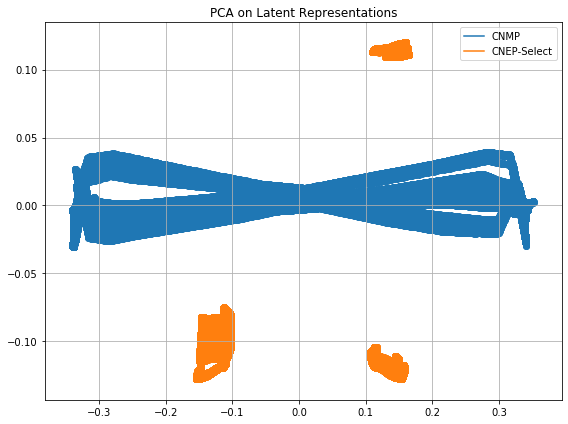

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

colors = [sns.color_palette('tab10')[0], sns.color_palette('tab10')[1]]
sns.set_palette('tab10')

plt.figure(figsize=(8, 6))

for i in range(len(test_inds)):
    # Apply PCA to cnp
    pca = PCA(n_components=2)
    cnp_lat_reduced = pca.fit_transform(cnp_lat_rep[i])

    # Apply the same transformation to wta
    wta_lat_reduced = pca.transform(wta_lat_rep[i])
    # Now we have two tensors of size (num_tests, 2)

    # Plotting
    plt.scatter(cnp_lat_reduced[:, 0], cnp_lat_reduced[:, 1], color=colors[0])
    plt.scatter(wta_lat_reduced[:, 0], wta_lat_reduced[:, 1], color=colors[1])

line0 = Line2D([0], [0], label=f'CNMP', color=colors[0])
line1 = Line2D([0], [0], label=f'CNEP-Select', color=colors[1])

handles = [line0, line1]

plt.grid(True)
plt.title('PCA on Latent Representations')

plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(f'{out_path}pca_.png')
plt.show()

In [7]:
# single obs. between y[0, 0] and y[1, 0], tar full trajectory
num_test = 100

obs = torch.zeros(num_test, 1, 2)

obs[:, 0, 0] = 0.5
obs[:, 0, 1] = (torch.linspace(y[0, 99, 0], y[1, 99, 0], num_test+2))[1:-1]  # +2 to include the end points, 1:-1 to exclude the end points
tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1)

plt_y_lim = torch.max(y) + 0.1

comp_path = f'{root_path}{run_id}/comparison/'

if not os.path.exists(comp_path):
    os.makedirs(comp_path)

for i in range(num_test):
    plt.ylim((-plt_y_lim, plt_y_lim))
    o = obs[i].unsqueeze(0)
    with torch.no_grad():
        pred_cnp, _ = cnp(o, tar)
        pred_wta, gate = wta(o, tar)

    
    plt.plot(torch.linspace(0, 1, 200), pred_cnp[0,:,0])

    
    plt.plot(torch.linspace(0, 1, 200), pred_wta[0,0,:,0], 'tomato', alpha=max(0.2, gate[0, 0, 0].item()))
    plt.plot(torch.linspace(0, 1, 200), pred_wta[1,0,:,0], 'lightcoral', alpha=max(0.2, gate[0, 0, 1].item()))

    plt.scatter(obs[i, 0, 0], obs[i,0,1], c='k')
    plt.plot(torch.linspace(0, 1, 200), y[0], 'k', alpha=0.25)
    plt.plot(torch.linspace(0, 1, 200), y[1], 'k', alpha=0.25)

    line = Line2D([0], [0], label=f'CNP', color='b')
    line0 = Line2D([0], [0], label=f'CNEP-0: {gate[0, 0, 0].item():.4f}', color='tomato')
    line1 = Line2D([0], [0], label=f'CNEP-1: {gate[0, 0, 1].item():.4f}', color='lightcoral')

    handles = [line, line0, line1]

    plt.grid(True)
    plt.legend(handles=handles, loc='best')
    plt.savefig(f'{root_path}{run_id}/comparison/int_{i}.png')
    plt.close()